
<img src=https://www.iteda.cnea.gov.ar/sites/default/files/garland_iteda_logo.png align='left' height=115>

<img src=https://www.facet.unt.edu.ar/facetinforma/wp-content/uploads/sites/9/2015/11/it-OP1-Transparente.png align='right' height=115>


# Análisis Estadístico de Datos

Segundo cuatrimestre 2023





## Trabajo Práctico 7 - Ajuste de Datos


In [ ]:
# This module provides a collection of utility functions for statistical data analysis
# including linear least squares fitting, covariance ellipse calculation, cost functions, and more.
# It also includes functions for analyzing parameter estimators and statistical properties.

# Standard Library Imports
import math
from pathlib import PurePath
from typing import Tuple

# Third-Party Imports
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
from scipy.stats import chi2
from scipy.stats import binned_statistic


def get_ellipse(center: np.ndarray, cova: np.ndarray, nsigma: int = 1, npoints: int = 1000) -> np.ndarray:
    """
    Return the coordinates of a covariance ellipse.

    Args:
        center (np.ndarray): The center of the ellipse.
        cova (np.ndarray): The covariance matrix.
        nsigma (int, optional): The number of standard deviations for the ellipse. Defaults to 1.
        npoints (int, optional): The number of points to generate on the ellipse. Defaults to 1000.

    Returns:
        np.ndarray: The coordinates of the ellipse.
    """
    cholesky_l = np.linalg.cholesky(cova)
    t = np.linspace(0, 2 * np.pi, npoints)
    circle = np.column_stack([np.cos(t), np.sin(t)])
    ellipse = nsigma * circle @ cholesky_l.T + center
    return ellipse.T


def linear_least_squares(model_matrix: np.ndarray, y: np.ndarray, ysigma: np.ndarray) -> dict:
    """
    Fit data with a linear least squares method.

    Args:
        model_matrix (np.ndarray): Model/design/X matrix.
        y (np.ndarray): Dependent variable.
        ysigma (np.ndarray): Y errors.

    Returns:
        dict: Dictionary containing parameter estimators, errors, covariance matrix, correlation matrix,
        chi-squared minimum, degrees of freedom, and p-value.
    """

    # Parameter estimators
    cova_y = np.diag(ysigma * ysigma)
    cova_par = inv(model_matrix.T @ inv(cova_y) @ model_matrix)
    matrix_b = cova_par @ model_matrix.T @ inv(cova_y)
    theta_est = matrix_b @ y

    # Parameter errors
    errors = np.sqrt(np.diagonal(cova_par))
    corr = cova_par / np.tensordot(errors, errors, axes=0)

    # Goodness of fit
    residuals = y - model_matrix @ theta_est
    chi2_min = residuals.T @ inv(cova_y) @ residuals
    ndof = len(y) - len(theta_est)
    pvalue = chi2.sf(chi2_min, ndof)

    return {
        'est': theta_est,
        'errors': errors,
        'cova': cova_par,
        'corr': corr,
        'chi2_min': chi2_min,
        'ndof': ndof,
        'pvalue': pvalue
    }


def cost_poisson(y: np.ndarray, mu: np.ndarray) -> float:
    """
    Cost function of a Poisson variable.

    Args:
        y (np.ndarray): Measured values of the dependent variable.
        mu (np.ndarray): Model values at each measured data point.

    Returns:
        float: Fit cost.
    """
    cost_array = 2 * (mu - y) - 2 * y * np.log(mu / y)
    return cost_array.sum()


def fit_errors(grad: np.ndarray, cova: np.ndarray) -> np.ndarray:
    """
    Calculate the fit errors by propagating the parameter errors.

    Args:
        grad (np.ndarray): Gradient of the fit model with respect to the parameters.
        cova (np.ndarray): Covariance matrix of the fit parameters.

    Returns:
        np.ndarray: Fit errors.
    """
    var_mu_est = np.einsum("ki,ij,kj->k", grad, cova, grad)
    sigma_mu_est = np.sqrt(var_mu_est)
    return sigma_mu_est


def get_bias(estimators: np.ndarray, parameter: float) -> Tuple[float, float]:
    """
    Estimate the bias of a parameter estimator.

    Args:
        estimators (np.ndarray): Array of parameter estimators.
        parameter (float): True parameter value.

    Returns:
        tuple: Bias and standard error of the estimator.
    """
    mean = np.mean(estimators)
    bias = mean - parameter
    sigma = np.std(estimators, ddof=1)
    sigma_mean = sigma / math.sqrt(len(estimators))
    return bias, sigma_mean


def get_coverage(estimators: np.ndarray, errors: np.ndarray, parameter: float) -> Tuple[float, float]:
    """
    Estimate the coverage of the confidence intervals.

    Args:
        estimators (np.ndarray): Array of parameter estimators.
        errors (np.ndarray): Array of parameter errors.
        parameter (float): True parameter value.

    Returns:
        tuple: Coverage and its standard error.
    """
    theta_min = np.array(estimators) - np.array(errors)
    theta_max = np.array(estimators) + np.array(errors)
    hits = ((parameter - theta_min) * (parameter - theta_max) < 0).sum()
    ndata = len(estimators)
    coverage = hits / ndata
    coverage_error = math.sqrt(coverage * (1 - coverage) / ndata)
    return coverage, coverage_error


def get_pvalue(chi2_sim: list, chi2_obs: float) -> Tuple[float, float]:
    """
    Calculate the p-value of a chi-squared test.

    Args:
        chi2_sim (list): List of simulated chi-squared values.
        chi2_obs (float): Observed chi-squared value.

    Returns:
        tuple: P-value and its standard error.
    """
    ntail = np.sum(np.array(chi2_sim) > chi2_obs)
    ndata = len(chi2_sim)
    pvalue = ntail / ndata
    pvalue_error = math.sqrt(pvalue * (1 - pvalue) / ndata)
    return pvalue, pvalue_error


def savefigs(basename: str, formats: tuple = ('.eps', '.pdf', '.png', '.svg'), folder: str = '') -> None:
    """
    Save a figure to multiple formats and print their names.

    Args:
        basename (str): Base filename for the saved figures.
        formats (tuple, optional): Tuple of file formats to save. Defaults to ('.eps', '.pdf', '.png', '.svg').
        folder (str, optional): Folder where the figures will be saved. Defaults to ''.
    """
    fig = plt.gcf()
    for fig_format in formats:
        figure_name = PurePath(folder, basename + fig_format)
        print(f'Saving figure to {figure_name}')
        fig.savefig(figure_name)


def profile_histogram(x: np.ndarray, y: np.ndarray, bins: int, histo_range: tuple = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute a profile histogram.

    Args:
        x (np.ndarray): The x-values.
        y (np.ndarray): The y-values.
        bins (int): The number of bins.
        histo_range (tuple, optional): Range for the histogram. Defaults to None.

    Returns:
        tuple: Counts, means, standard deviations, and bin edges.
    """

    counts, bin_edges, __ = binned_statistic(x, y, statistic='count', bins=bins, range=histo_range)
    means, __, __ = binned_statistic(x, y, statistic='mean', bins=bins, range=histo_range)
    means2, __, __ = binned_statistic(x, y*y, statistic='mean', bins=bins, range=histo_range)

    # Standard deviations with Bessel correction
    variances = counts * (means2 - means**2) / (counts-1)
    standard_deviations = np.sqrt(variances)

    return counts, means, standard_deviations, bin_edges


def array_rms(array):
    """
    Calculate the root of the mean of the squares of an array

    Args:
        array (np.array): input array

    Returns:
         square root of the mean of the array elements
    """
    return math.sqrt(np.mean(array ** 2))

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import minimize
import pandas as pd

In [ ]:
# Para cargar archivos alojados en Colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# bajar módulo sda.py e importar
dat_fil_Gid2 = '1Wm3uae2m7ZwXsn_02ZE1Qv7F_TM-KClm'
downloaded2 = drive.CreateFile({'id':dat_fil_Gid2})
downloaded2.GetContentFile('sda.py')
import sda

ApiRequestError: ignored

### Ajuste de la eficiencia

**1.** Considerar una variable aleatoria $k$ que sigue una distribución binomial
con un número de pruebas de Bernoulli $n=30$ y probabilidad de éxito
o eficiencia $p$. Calcular la función de verosimilitud $L(p)$, el estimador
de máxima verosimilitud $\hat{p}$, la verosimilitud máxima $L_{max}$, el cociente de verosimilitudes $λ(p)$ y la función de costo $J_1(p)$ para los casos:

* k = 0
* k = 10
* k = n



distribucion Binomial

$$
P(k) = {n\choose k} p^k (1 - p)^{n-k}
$$

Para abordar este problema, primero definimos la función de verosimilitud

$L(p)$, que describe la probabilidad de observar los datos

k dadas las pruebas de Bernoulli

$n$ y la probabilidad de éxito

$p$. La función de verosimilitud se puede expresar utilizando la distribución binomial:

 función verosimilitud  $L(p)$

$$
{
L(p) = {n\choose k} p^k (1 - p)^{n-k}
}
$$

estimador $\hat{p}$ :

$$
\hat{p} = k/n
$$
El estimador de máxima verosimilitud
$
\hat{p}
$
​
  se obtiene maximizando la función de verosimilitud respecto a

$p$. Esto se puede hacer derivando


$L(p)$ con respecto a

$p$, igualando a cero y resolviendo para

$p$. En este caso, dado que estamos tratando con la distribución binomial,

$\hat{p}$
  es simplemente



$k/n$.

La verosimilitud máxima


$L
max$

​
  se obtiene al evaluar la función de verosimilitud en el estimador de máxima verosimilitud
$\hat{p}$
 :
máxima verosimilitud $L_{max}$:

$$
{
L_{max} = L(\hat{p}) = {n\choose k} \hat{p}^k (1 - \hat{p})^{n-k}
}
$$

 cociente de verosimilitudes $\lambda(p)$

$$
 \lambda(p) = L(p)/L_{max}
$$

para evitar indeterminaciones, $\lambda(p)$  es



\begin{equation}
\boxed{
\lambda(p) =
    \begin{cases}
        \frac{p^k (1 - p)^{n-k}}{\hat{p}^k (1 - \hat{p})^{n-k}} & \text{si } 0 < \hat{p} < 1\\
        p^k (1 - p)^{n-k} & \text{si } \hat{p} = 0 \text{ o } \hat{p} = 1
    \end{cases}
}
\end{equation}


Finalmente, la función de costo

$J (p)$ se define en términos del negativo del logaritmo del cociente de verosimilitudes. Esto se hace para simplificar cálculos y es una forma común de expresar funciones de costo en estadística:
$$
J(p) = -2 \ log(\lambda(p))
$$

Usando el resultado anterior, queda la función en ramas:

\begin{equation}
\boxed{
J(p) =
    \begin{cases}
        -2 (n-k) log (1-p)   & \text{si } k = 0\\
        -2k \ log(p/\hat{p}) - 2(n-k) log[(1-p)/(1-\hat{p})] & \text{si } 0 < k < n\\
        -2 k \ log (p) & \text{si } k = n
    \end{cases}
}
\end{equation}

In [ ]:
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt

def binomial(n, k, p):
    return comb(n, k) * p**k * (1-p)**(n-k)

def costo_binomial(p, k, n, p_hat):
    if p_hat == 0:
        return -2*(n-k)*np.log(1-p)
    if p_hat == 1:
        return -2*k*np.log(p)
    return -2*k*np.log(p/p_hat) - 2*(n-k)*np.log((1-p)/(1-p_hat))

def cociente_likelihood(p, k, n):
    p_hat = k/n
    if k == 0 or k == n:
        return p**k * (1-p)**(n-k)
    return (p**k * (1-p)**(n-k)) / (p_hat**k * (1-p_hat)**(n-k))

n = 30
ks = [0, 10, n]

for k in ks:
    print("\n" , f"k = {k}", "\n")
    L = lambda p: binomial(n, k, p)  # likelihood
    p_hat = k/n  # estimador máx. likelihood
    Lmax = L(p_hat)
    lambda_val = cociente_likelihood(p_hat, k, n)
    J = costo_binomial(p_hat, k, n, p_hat)

    # Imprimir estimador, Lmax, cociente de verosimilitudes y función de costo
    print(f"p_hat = k/n = {p_hat}")
    print(f"Lmax = {Lmax}")
    print(f"Cociente de verosimilitudes (lambda): {lambda_val}")
    print(f"Función de costo (J): {J}")



 k = 0 

p_hat = k/n = 0.0
Lmax = 1.0
Cociente de verosimilitudes (lambda): 1.0
Función de costo (J): -0.0

 k = 10 

p_hat = k/n = 0.3333333333333333
Lmax = 0.15301524319249124
Cociente de verosimilitudes (lambda): 1.0
Función de costo (J): -0.0

 k = 30 

p_hat = k/n = 1.0
Lmax = 1.0
Cociente de verosimilitudes (lambda): 1.0
Función de costo (J): -0.0


**2.** Graficar la función de costo $J_1(p)$ para los tres casos anteriores.

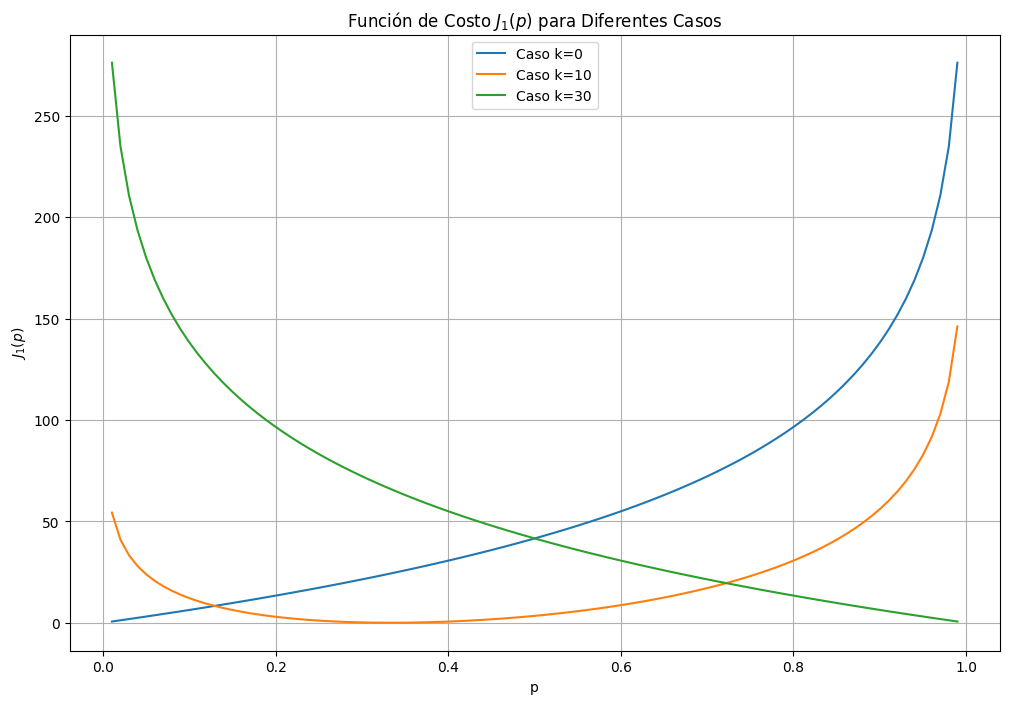

In [ ]:

from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt

def binomial(n, k, p):
    return comb(n, k) * p**k * (1-p)**(n-k)

def costo_binomial(p, k, n, p_hat):
    if p_hat == 0:
        return -2*(n-k)*np.log(1-p)
    if p_hat == 1:
        return -2*k*np.log(p)
    return -2*k*np.log(p/p_hat) - 2*(n-k)*np.log((1-p)/(1-p_hat))

def cociente_likelihood(p, k, n):
    p_hat = k/n
    if k == 0 or k == n:
        return p**k * (1-p)**(n-k)
    return (p**k * (1-p)**(n-k)) / (p_hat**k * (1-p_hat)**(n-k))

n = 30
ks = [0, 10, n]

# Rango de valores de p
p_values = np.linspace(0.01, 0.99, 100)

# Graficar las funciones de costo
plt.figure(figsize=(12, 8))

for k in ks:
    J_values = [costo_binomial(p, k, n, k/n) for p in p_values]
    plt.plot(p_values, J_values, label=f'Caso k={k}')

plt.title('Función de Costo $J_1(p)$ para Diferentes Casos')
plt.xlabel('p')
plt.ylabel('$J_1(p)$')
plt.legend()
plt.grid(True)
plt.show()


**3.** En un experimento se midieron los 20 datos de la tabla que contiene la variable independiente $x$ (columna 1), el número de pruebas de Bernoulli $n$ (columna 2) y el número de éxitos $k$ (columna 3). Graficar los datos usando el eje horizontal para la variable independiente $x$ y el eje vertical para el estimador de la eficiencia calculado a partir de $k$ y $n$.


In [ ]:
x = np.arange(start=0.05, stop=1.05, step=0.05)
npruebas = 30
n = np.full(x.shape, npruebas)
k = np.array([0, 0, 0, 3, 3, 2, 8, 5, 4, 11, 18, 15, 19, 20, 26, 24, 26, 29, 30, 30])
df = pd.DataFrame(data = {'x': x, 'n': n, 'k': k})
df

,x,n,k
0,0.05,30,0
1,0.10,30,0
2,0.15,30,0
3,0.20,30,3
4,0.25,30,3
5,0.30,30,2
6,0.35,30,8
7,0.40,30,5
8,0.45,30,4
9,0.50,30,11


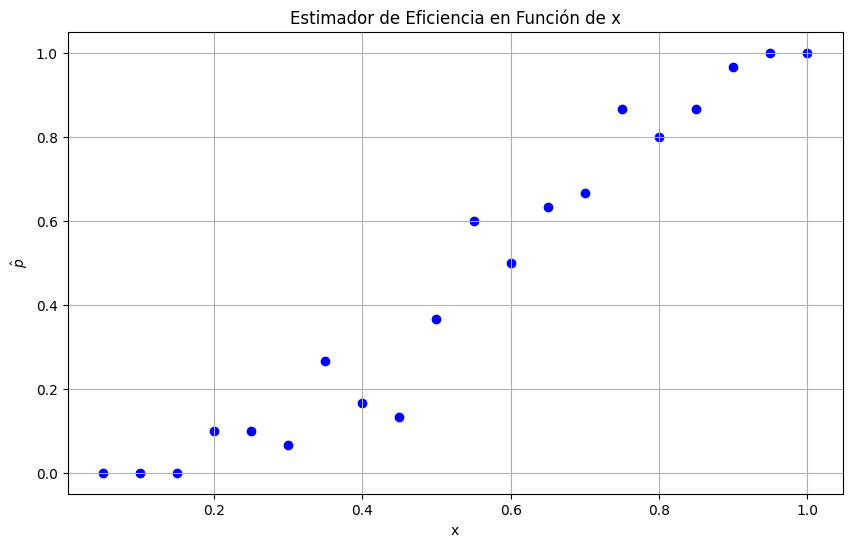

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Datos proporcionados
x = np.arange(start=0.05, stop=1.05, step=0.05)
npruebas = 30
n = np.full(x.shape, npruebas)
k = np.array([0, 0, 0, 3, 3, 2, 8, 5, 4, 11, 18, 15, 19, 20, 26, 24, 26, 29, 30, 30])
df = pd.DataFrame(data={'x': x, 'n': n, 'k': k})

# Calcular el estimador de eficiencia (p_hat)
df['p_hat'] = df['k'] / df['n']

# Graficar los puntos sin unirlos por líneas
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['p_hat'], marker='o', color='b')
plt.title('Estimador de Eficiencia en Función de x')
plt.xlabel('x')
plt.ylabel('$\hat{p}$')
plt.grid(True)
plt.show()



**4.** El modelo a ajustar es la función sigmoide,
\begin{equation}
s(x;a,b)=\frac{1}{1+\exp(-(x-a)/b)},
\end{equation}
con $a$ y $b$ los parámetros del ajuste. En base al modelo $s(x)$ y a la
función de costo $J_1(p)$ escribir el código para la función de costo del
ajuste $J(\theta)$ con $\theta = (a, b)$.

La función de costo del ajuste, denotada como $J(\theta)$, se obtiene sumando los costos individuales de cada bin, representados por $J_i(\theta)$. Dado que cada bin sigue una distribución normal, podemos expresar estos costos de la siguiente manera:

\begin{equation}
\
    \begin{cases}
        -2 (n-k) log (1-s_i(\theta) )   & \text{si } k = 0\\
        -2k \ log(s_i(\theta) /y_i) - 2(n-k) log[(1-s_i(\theta) )/(1-y_i)] & \text{si } 0 < k < n\\
        -2 k \ log (s_i(\theta) ) & \text{si } k = n
    \end{cases}
\end{equation}


donde

$$
s_i(\theta) = s(x_i; \theta) \\
y_i = k_i/n_i
$$

con  $x_i$, $k_i$ y $n_i$ datos de las mediciones

In [ ]:
def modelo(x, theta):
  a, b = theta
  return 1/(1 + np.exp(-(x-a)/b))

def costo(theta, train_data):
  x = train_data["x"]
  k = train_data["k"]
  n = train_data["n"]
  p_hat = k/n
  p = modelo(x, theta) # modelo

  costos_i = []

  for i in range(len(x)):
    costos_i.append(costo_binomial(p[i], k[i], n[i], p_hat[i]))

  return sum(costos_i)

J = lambda theta : costo(theta, df)


**5.** Minimizar el costo del ajuste $J(\theta)$ usando como semilla inicial $a=0.5$ y $b=0.1$. Calcular los estimadores de máxima verosimilitud y los errores
de los parámetros $a$ y $b.$ Calcular la correlación entre los estimadores de $a$ y $b$.

In [ ]:
from scipy.optimize import minimize

theta_0 = [0.5, 0.1]
res = minimize(J, x0=theta_0)
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 24.01055559005026
        x: [ 5.715e-01  1.210e-01]
      nit: 10
      jac: [ 1.907e-06  1.669e-06]
 hess_inv: [[ 1.046e-04  2.007e-06]
            [ 2.007e-06  4.203e-05]]
     nfev: 42
     njev: 14

In [ ]:
theta_est = res.x
cova = 2 * res.hess_inv
error = np.sqrt( np.diagonal(cova) )
rho = cova[0][1]/(error[0]*error[1])
print(f'a_hat = {theta_est[0]:.3f} ± {error[0]:.3f}')
print(f'b_hat = {theta_est[1]:.3f} ± {error[1]:.3f}')
print(f'ρ = {rho:.2f}')

a_hat = 0.571 ± 0.014
b_hat = 0.121 ± 0.009
ρ = 0.03


**6.** Calcular el χ2 del ajuste y su p-valor.



In [ ]:
chi2_min = res.fun
ndof = len(df["x"]) - len(theta_est)
pvalor = chi2.sf(chi2_min, ndof)
print(f'χ²min = {chi2_min:.1f}')
print(f'ndof = {ndof}')
print(f'pvalor = {pvalor:.3%}')

χ²min = 24.0
ndof = 18
pvalor = 15.468%


**7.** Calcular la banda de error del ajuste considerando que las derivadas del modelo con respecto a los parámetros son:

\begin{equation}
\frac{\partial s}{\partial a} = -s \, (1-s) \,  \left(\frac{1}{b} \right)
\end{equation}

\begin{equation}
\frac{\partial s}{\partial b} = -s \, (1-s) \,  \left( \frac{x-a}{b^2} \right).
\end{equation}

In [ ]:
x = np.linspace( df.x.min()-0.05, df.x.max()+0.05, 512)

s_est = modelo(x, theta_est)
grad_theta1 = -s_est*(1-s_est)*(1/theta_est[1])
grad_theta2 = -s_est*(1-s_est)*(x-theta_est[0])/(theta_est[1]**2)
grad = np.column_stack( (grad_theta1, grad_theta2) )

sigma_mu_est = fit_errors(grad, cova)

**8.** Graficar los datos y el ajuste incluyendo la banda de error.

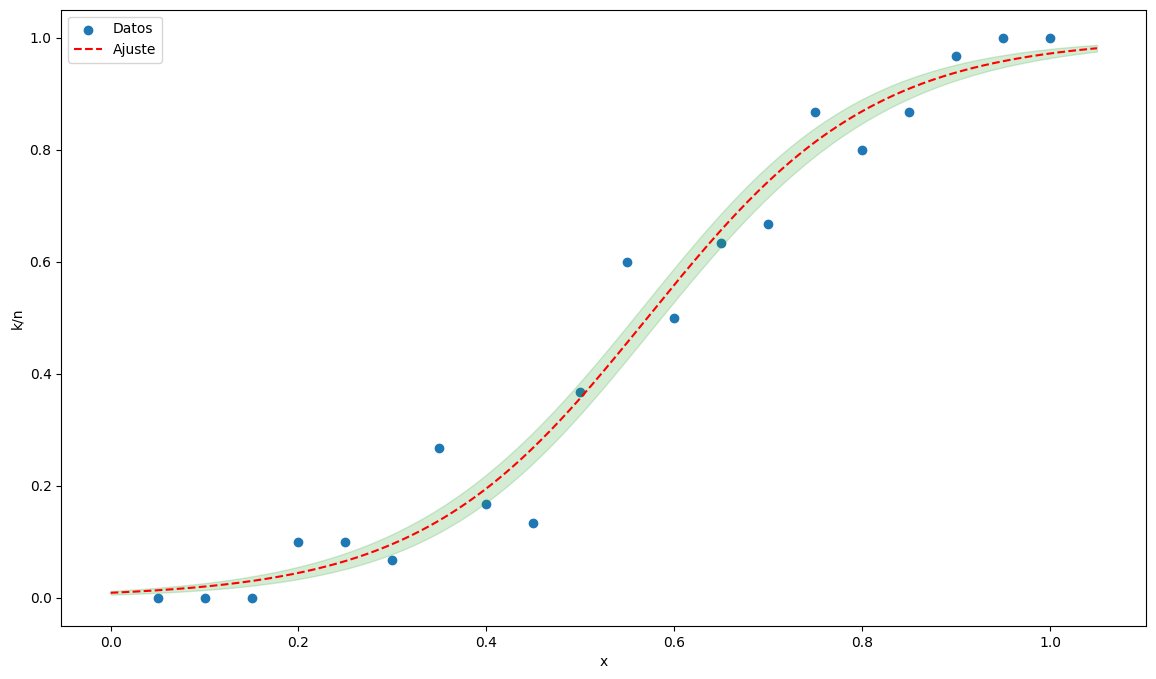

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))
ax.set_ylabel('k/n')
ax.set_xlabel('x')
ax.scatter(df["x"], df["k"]/df["n"],label='Datos')
ax.plot(x, s_est, "--", color="red", label='Ajuste')
ax.legend(fontsize='medium')

sigma_mu_est = fit_errors(grad, cova)
ax.fill_between(x, s_est-sigma_mu_est, s_est+sigma_mu_est, color='tab:green', alpha=0.2)
plt.show()